# <center><font face="STCAIYUN" color=blue size=7>C H I S E L</font></center>

# 第4章    Chisel常用的硬件原语
---
<font face="宋体" size=3>前一章介绍了一些基本的数据类型和硬件类型，已经足够编写基本的小规模电路。至于要如何生成Verilog，会在后续章节讲解。如果要编写大型电路，当然也可以一砖一瓦地搭建，但是费时费力，完全体现不出软件语言的优势。Chisel在语言库里定义了很多常用的硬件原语，读者可以直接导入相应的包来使用。让编译器多干活，让程序员少费力。</font>
# <font face="宋体" size=3>设置</font>

In [ ]:
val path = System.getProperty("user.dir") + "/source/load-ivy.sc"
interp.load.module(ammonite.ops.Path(java.nio.file.FileSystems.getDefault().getPath(path)))

In [ ]:
import chisel3._
import chisel3.util._
import chisel3.tester._
import chisel3.tester.RawTester.test
import chisel3.stage.ChiselGeneratorAnnotation

***

## 多路选择器
<font face="宋体" size=3>多路选择器是一个很常用的电路模块，所以Chisel内建了几种多路选择器：
</font>
#### 二输入多路选择器
<font face="宋体" size=3>其形式为“Mux(sel, in1, in2)”。sel是Bool类型，in1和in2的类型相同，都是Data的任意子类型。当sel为true.B时，返回in1，否则返回in2。因为Mux仅仅是把一个输入返回，所以Mux可以内嵌Mux，构成n输入多路选择器，类似于嵌套的三元操作符。其形式为：</font>

#### MuxCase
<font face="宋体" size=3>MuxCase是针对上述n输入多路选择器的简便写法，形式为“MuxCase(default, Array(c1 -> a, c2 -> b, ...))”，它的展开与嵌套的Mux是一样的。第一个参数是默认情况下返回的结果，第二个参数是一个数组，数组的元素是对偶“(成立条件，被选择的输入)”；</font>
#### MuxLookup
<font face="宋体" size=3>MuxLookup是MuxCase的变体，它相当于把MuxCase的成立条件依次换成从0开始的索引值，就好像一个查找表，其形式为“MuxLookup(idx, default, Array(0.U -> a, 1.U -> b, ...))”；
</font>
#### Mux1H
<font face="宋体" size=3>Mux1H是chisel3.util包里的独热码多路选择器，它的选择信号是一个独热码。如果零个或多个选择信号有效，则行为未定义。它有以下几种常用的定义形式：
</font>

In [ ]:
val hotValue = Mux1H(io.selector,Seq(2.U,4.U,8.U,11.U))
val hotValue = Mux1H(Seq(io.selector(0),io.selector(1),
io.selector(2),io.selector(3)),Seq(2.U,4.U,8.U,11.U))
val hotValue = Mux1H(Seq(
    io.selector(0) -> 2.U,
    io.selector(1) -> 4.U,
    io.selector(2) -> 8.U,
    io.selector(3) -> 11.U
))

<font face="宋体" size=3>以上三种形式是等价的，io.selector是一个UInt类型的数据，并且位宽不能小于待选择数据的个数。在第一种形式中，Mux1H会从低到高依次将io.selector的每一位作为一个选择信号，并和提供的被选择数据一一对应。
</font>

#### PriorityMux
<font face="宋体" size=3>优先级选择器PriorityMux，当多个选择信号有效时，按照定义时的顺序，返回更靠前的被选数据。</font>

In [ ]:
val priorityValue = PriorityMux(io.selector,Seq(2.U,4.U,8.U,11.U))
val priorityValue = PriorityMux(Seq(io.selector(0),io.selector(1),
io.selector(2),io.selector(3)),
Seq(2.U,4.U,8.U,11.U))
val priorityValue = PriorityMux(Seq(
    io.selector(0) -> 2.U,
    io.selector(1) -> 4.U,
    io.selector(2) -> 8.U,
    io.selector(3) -> 11.U,
  ))

<font face="宋体" size=3>以上三种定义形式是等价的，io.selector是一个Bits类型的数据，位宽不小于待选择数据的个数。
一般在Verilog中我们使用case语句来构建多路选择器，其所有分支处于同一优先级。
</font>

<font face="宋体" size=3>内建的多路选择器会转换成Verilog的三元操作符“**? :**”，这对于构建组合逻辑而言是完全足够的，而且我们更推荐这种做法，所以when语句常用于给寄存器赋值，而很少用来给线网赋值。 </font>

### 优先编码器

|编码器|定义形式|返回值类型|
|:----:|:----:|:----:|
|PriorityEncoder|PriorityEncoder("b1010".U)|返回值类型都是UInt，值为1.U|
|PriorityEncoder|PriorityEncoder(Seq(true.B, false.B, true.B, false.B))|返回值类型都是UInt，值为1.U|
|PriorityEncoderOH|PriorityEncoderOH("b1010".U)|返回一个UInt的数据2.U|
|PriorityEncoderOH|PriorityEncoderOH(Seq(false.B, true.B, true.B, false.B))|返回一个Seq：Seq(false.B, true.B, false.B, false.B)|



<font face="宋体" size=3>它和第一种编码器的区别在于该编码器会把编码结果转换成独热码。第一种形式返回一个UInt的数据2.U，第二种形式返回一个Seq：Seq(false.B, true.B, false.B, false.B)。
一般在Verilog中为了保证优先级别，我们常使用if…else if的组合来构建优先译码器。
 </font>

### 仲裁器
<font face="宋体" size=3>Chisel内建了两种仲裁器，一种是优先仲裁器，另一种是循环仲裁器。
</font>
<font face="宋体" size=3>（1）优先仲裁器Arbiter在chisel3.util包下面，只定义了Arbiter类，没有单例对象，所以每次都需要通过new来创建Arbiter对象。</font>              
<font face="宋体" size=3>（2）循环仲裁器RRArbiter也在chisel3.util包下面，并且只定义了RRArbiter类，没有单例对象，所以每次都需要通过new来创建RRArbiter对象。它的创建与调用方式和Arbiter是一样的，只是内部实现的仲裁逻辑不同。</font>         
<font face="宋体" size=3>下面定义一个二选一仲裁器MyArbiter，并在代码中例化了Arbiter：</font>  

In [ ]:
class MyArbiter extends Module {
  val io = IO(new Bundle {
      val in = Flipped(Vec(2, Decoupled(UInt(8.W))))
      val out = Decoupled(UInt(8.W))
      val chosen = Output(UInt())
  })
  val arbiter = Module(new Arbiter(UInt(8.W), 2))  // 2 to 1 Priority Arbiter
  arbiter.io.in <> io.in
  io.out <> arbiter.io.out
  io.chosen := arbiter.io.chosen
}

### 队列
<font face="宋体" size=3>Chisel内建了队列Queue，它会创建一个使用ready-valid接口的FIFO，在chisel3.util包下面既定义了Queue类，也定义了其单例对象，所以有两种创建Queue对象的方式。      
    Queue内部使用QueueIO定义端口，QueueIO最终仍然是使用Decoupled()创建所需的ready-valid接口，定义如下：
</font>


In [ ]:
class QueueIO[T <: Data](private val gen: T, val entries: Int) extends Bundle
{ 
   val enq = Flipped(EnqIO(gen))
   val deq = Flipped(DeqIO(gen))
   val count = Output(UInt(log2Ceil(entries + 1).W))
}
object EnqIO {
  def apply[T<:Data](gen: T): DecoupledIO[T] = Decoupled(gen)
}
object DeqIO {
  def apply[T<:Data](gen: T): DecoupledIO[T] = Flipped(Decoupled(gen))
}

<font face="宋体" size=3>enq是用来写数据的端口，因此它和数据生产者producer连接；deq是用来读数据的端口，因此它和数据接收者consumer连接；count表示此时Queue中的数据个数。
可以通过以下两种形式使用Queue：
</font>

<font face="宋体" size=3>**new Queue(gen: T,entries: Int)**:第一个参数是存储数据的类型，第二个参数是存储数据的深度。该方式返回的是一个Queue对象，该对象包含QueueIO属性，因此我们可以在代码中访问QueueIO的enq、deq和count这三种端口信号。     
**Queue(enq: ReadyValidIO[T],entries: Int = 2)**:第一个参数是ReadyValidIO类型的端口，第二个参数是存储数据的深度，默认值为2。该方式返回的是DecoupledIO[T]类型的读数据端口，也即上述的deq，因此我们不能在代码中访问enq和count。
</font>

In [ ]:
//第一种形式的使用案例：

class MyQueue extends Module {
  val io = IO(new Bundle {
    val in = Flipped(Decoupled(UInt(8.W)))
    val out = Decoupled(UInt(8.W))
    val cnt = Output(UInt(4.W))
  })
  val q = Module(new Queue(UInt(8.W), entries = 16))
  q.io.enq <> io.in
  io.out <> q.io.deq
  io.cnt := q.io.count
 }

In [ ]:
//第二种形式的使用案例：

class MyQueue extends Module {
    val io = IO(new Bundle {
    val in = Flipped(Decoupled(UInt(8.W)))
    val out = Decoupled(UInt(8.W))
  })
    val q = Queue(io.in, 2)
    io.out <> q
}


### ROM

<font face="宋体" size=3>可以通过工厂方法“VecInit[T <: Data](elt0: T, elts: T*)”或“VecInit[T <: Data](elts: Seq[T])”来创建一个只读存储器，参数就是ROM里的常量数值，对应的Verilog代码就是给读取ROM的线网或寄存器赋予常量值。在Verilog中我们常用寄存器组的方式构建ROM。
</font>

In [ ]:
// rom.scala
class ROM extends Module {
  val io = IO(new Bundle {
    val sel = Input(UInt(2.W))
    val out = Output(UInt(8.W))  
  })
 
  val rom = VecInit(1.U, 2.U, 3.U, 4.U)
 
  io.out := rom(io.sel)
}

<font face="宋体" size=3>在这个例子里需要提的一点是，Vec[T]类的apply方法不仅可以接收Int类型的索引值，另一个重载版本还能接收UInt类型的索引值。所以对于承担地址、计数器等功能的部件，可以直接作为由Vec[T]构造的元素的索引参数，比如这个例子中根据sel端口的值来选择相应地址的ROM值。
</font>

### RAM

<font face="宋体" size=3>Chisel支持两种类型的RAM:    
(1)RAM是同步(时序)写，异步(组合逻辑)读，通过工厂方法“Mem[T <: Data](size: Int, t: T)”来构建,由于现代的FPGA和ASIC技术已经不再支持异步读RAM，所以这种RAM会被综合成寄存器阵列。       
(2)RAM则是同步(时序)读、写，通过工厂方法“SyncReadMem[T <: Data](size: Int, t: T)”来构建，这种RAM会被综合成实际的SRAM。在Verilog代码上，这两种RAM都是由reg类型的变量来表示的，区别在于第二种RAM的读地址会被地址寄存器寄存一次。
</font>

####    写RAM的语法是：

#### 读RAM的语法是：

<font face="宋体" size=3>以Xilinx公司的Vivado 2018.3为例，下面的单端口SRAM代码经过综合后会映射到FPGA上实际的BRAM资源，而不是寄存器：</font>

In [ ]:
// ram.scala
class SinglePortRAM extends Module {
  val io = IO(new Bundle {
    val addr = Input(UInt(10.W))
    val dataIn = Input(UInt(32.W))
    val en = Input(Bool())
    val we = Input(Bool())
    val dataOut = Output(UInt(32.W))  
  })
  val syncRAM = SyncReadMem(1024, UInt(32.W))
  when(io.en) {
    when(io.we) {
      syncRAM.write(io.addr, io.dataIn)
      io.dataOut := DontCare
    } .otherwise {
      io.dataOut := syncRAM.read(io.addr)
    }
  } .otherwise {
    io.dataOut := DontCare
  }
}


下面是Vivado综合后的部分截图，可以看到确实变成了实际的BRAM：

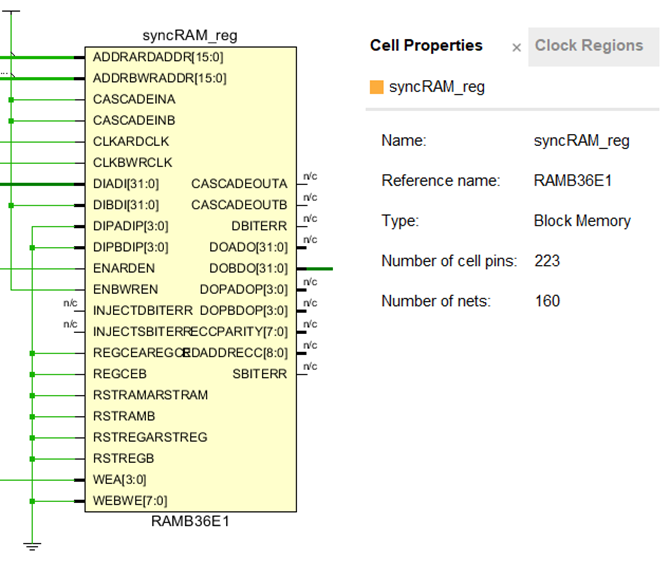

### 带写掩模的RAM

<font face="宋体" size=3>RAM通常都具备按字节写入的功能，比如数据写入端口的位宽是32bit，那么就应该有4bit的写掩模信号，只有当写掩模的比特位有效时，对应的字节才会写入。Chisel也具备构建带写掩模的RAM的功能。       
    当构建RAM的数据类型为Vec[T]时，就会推断出该RAM具有写掩模。此时，需要定义一个Seq[Bool]类型的写掩模信号，序列的元素个数为数据写入端口的位宽除以字节宽度。而write方法有一个重载版本，就是第三个参数是接收写掩模信号的。当下标为0的写掩模比特是true.B时，最低的那个字节会被写入，依次类推。下面是一个带写掩模的单端口RAM：
</font>

In [ ]:
// maskram.scala
class MaskRAM extends Module {
  val io = IO(new Bundle {
    val addr = Input(UInt(10.W))
    val dataIn = Input(UInt(32.W))
    val en = Input(Bool())
    val we = Input(UInt(4.W))
val mask = Input(Vec(4, Bool()))
    val dataOut = Output(UInt(32.W))  
  })
  val dataIn_temp = Wire(Vec(4, UInt(8.W)))
  val dataOut_temp = Wire(Vec(4, UInt(8.W)))
  val syncRAM = SyncReadMem(1024, Vec(4, UInt(8.W)))
      dataOut_temp := DontCare
  	  when(io.en) {
         when(io.we){
           syncRAM.write(io.addr, dataIn_temp, io.mask)
         }.otherwise{
           dataOut_temp := syncRAM.read(io.addr)
         }
      } .otherwise {
        dataOut_temp := DontCare
      } 
  for(i <- 0 until 4) {
    dataIn_temp(i) := io.dataIn(8*i+7, 8*i)
    io.dataOut := Cat(dataOut_temp(3), dataOut_temp(2), dataOut_temp(1), dataOut_temp(0))
  }
}

### 计数器

<font face="宋体" size=3>计数器也是一个常用的硬件电路。在Chisel.util包里定义了一个自增计数器原语Counter，它的apply方法是：apply(cond: Bool, n: Int): (UInt, Bool)，接收两个参数：      
    （1）cond是Bool类型的使能信号，为true.B时计数器从0开始每个时钟上升沿加1自增，为false.B时则计数器保持不变；     
    （2）n是一个Int类型的具体正数，当计数到n时归零。     
    该方法返回一个二元组：其第一个元素是计数器当前的计数值，类型为UInt；第二个元素是判断当前计数值是否等于n的结果，类型为Bool。
</font>


<font face="宋体" size=3>另一个重载版本是apply(n: Int): Counter。和上述两个方法不同，该方法返回的是一个Counter对象，有如下的属性和方法可以使用：</font>

|属性和方法|作用|
|:----:|:----:|
|def inc(): Bool|随时钟使计数器+1，返回值表示计数器是否在下一个时钟周期结束|
|def n: Int|无参函数，返回计数器的计数最大值n|
|def range: Range|无参函数，返回计数器的计数范围，类型为Range|
|def reset(): Unit|使计数器复位到初始值0|
|val value: UInt|表示计数器此时的计数值，因为是val类型，所以只能读取|

<font face="宋体" size=3>假设我们想从0计数到233，分别使用上述三种版本的apply方法的写法如下：</font>

In [ ]:
//写法一：apply(cond: Bool, n: Int): (UInt, Bool)
class MyCounter extends Module {
  val io = IO(new Bundle {
    val en = Input(Bool())
    val out = Output(UInt(8.W))
    val valid = Output(Bool())  
  })

  val (a, b) = Counter(io.en, 233)
  io.out := a
  io.valid := b
}


In [ ]:
//写法二：def apply(r: Range, enable: Bool = true.B, reset: Bool = false.B): (UInt, Bool)
import scala.collection.immutable.Range
class MyCounter extends Module {
  val io = IO(new Bundle {
    val en = Input(Bool())
    val out = Output(UInt(8.W))
    val valid = Output(Bool())
  })

  val (a, b) = Counter(Range(0,233),io.en)
  io.out := a
  io.valid := b
}

In [ ]:
//写法三：apply(n: Int): Counter
class MyCounter extends Module {
  val io = IO(new Bundle {
    val en = Input(Bool())
    val out = Output(UInt(8.W))
    val valid = Output(Bool())
  })
  val cnt = Counter(233)

  when(io.en){
    cnt.inc()
  }

  val a = cnt.value
  val b = cnt.value === cnt.n.U

  io.out := a
  io.valid := b
}

### 线性反馈移位寄存器
<font face="宋体" size=3>如果要产生伪随机数，可以使用chisel3.util.random包里的线性反馈移位寄存器原语LFSR:
def apply(width: Int, increment: Bool = true.B, seed: Option[BigInt] = Some(1)): UInt     
    第一个参数width是移位寄存器的位宽;     
    第二个参数increment是一个Bool类型的使能信号，用于控制寄存器是否移位，缺省值为true.B;    
    第三个参数seed是一个随机种子，是可选值类型。
</font>

In [ ]:
// lfsr.scala
class LFSR16 extends Module {
  val io = IO(new Bundle {
    val en = Input(Bool())
    val out = Output(UInt(16.W))
  })

  io.out := LFSR(16,io.en,Some(1))
}

### 状态机
<font face="宋体" size=3>状态机也是常用电路，但是Chisel没有直接构建状态机的原语。不过，util包里定义了一个Enum特质及其伴生对象。伴生对象里的apply方法定义如下:def apply(n: Int): List[UInt]      
    它会根据参数n返回对应元素数的List[UInt]，每个元素都是不同的，所以可以作为枚举值来使用。最好把枚举状态的变量名也组成一个列表，然后用列表的模式匹配来进行赋值。有了枚举值后，可以通过“switch…is…is”语句来使用。其中，switch里是相应的状态寄存器，而每个is分支的后面则是枚举值及相应的定义。例如我们要检测持续时间超过两个时钟周期的高电平：
</font>

In [ ]:
// fsm.scala
class DetectTwoOnes extends Module {
  val io = IO(new Bundle {
    val in = Input(Bool())
    val out = Output(Bool())
  })
 
  val sNone :: sOne1 :: sTwo1s :: Nil = Enum(3)
  val state = RegInit(sNone)
 
  io.out := (state === sTwo1s)
 
  switch (state) {
    is (sNone) {
      when (io.in) {
        state := sOne1
      }
    }
    is (sOne1) {
      when (io.in) {
        state := sTwo1s
      } .otherwise {
        state := sNone
      }
    }
    is (sTwo1s) {
      when (!io.in) {
        state := sNone
      }
    }
  }
}
//注意，枚举状态名的首字母要小写，这样Scala的编译器才能识别成变量模式匹配

### 常见电路的描述方式
#### 向量
<font face="宋体" size=3>（1）如何定义向量</font>         
<font face="宋体" size=3>如果需要一个集合类型的数据，除了可以使用Scala内建的数组、列表、集等数据结构外，还可以使用Chisel专属的Vec[T]。T必须是Data的子类，而且每个元素的类型、位宽必须一样。
Vec[T]的伴生对象里有一个apply工厂方法，接收两个参数，第一个是Int类型，表示元素的个数，第二个是元素。它属于可索引的序列，下标从0开始。   
</font>

In [ ]:
val myVec = Wire(Vec(3, UInt(32.W)))

<font face="宋体" size=3>还有一个工厂方法VecInit[T]，通过接收一个Seq[T]（这里的Seq包括seq、array、list、tuple、queue等集合）作为参数来构造向量，或者是多个重复参数。不过，这个工厂方法常把有字面值的数据作为参数，用于初始化寄存器组、ROM、RAM等，或者用来构造多个模块。
</font>

In [ ]:
val Vec1 = VecInit(1.U, 2.U, 3.U, 4.U)//重复参数
val Vec2 = VecInit(Seq.fill(8)(0.U(8.W)))//序列

<font face="宋体" size=3>（2）混合向量</font>           
<font face="宋体" size=3>混合向量MixedVec[T]与普通的向量Vec[T]类似，只不过包含的元素可以不全都一样，比如位宽不一样。它的工厂方法是通过重复参数或者序列作为参数来构造的：</font>  


In [ ]:
val Vec1 = MixedVec(UInt(8.W), UInt(16.W), UInt(32.W))//重复参数
val Vec2 = MixedVec(Array(UInt(8.W), UInt(16.W), UInt(32.W)))//序列

<font face="宋体" size=3>并且也有一个叫MixedVecInit[T]的单例对象，也是通过重复参数或者序列作为参数来构造的：<font>

In [ ]:
val Vec1 = MixedVecInit(1.U, 2.U, 3.U, 4.U)//重复参数
val Vec2 = MixedVecInit(Seq.fill(8)(0.U(8.W)))//序列

<font face="宋体" size=3>从上面也看出来了，对于可以传入序列的向量，它们的序列参数并不一定要逐个手写，可以通过Scala的函数，比如fill、map、flatMap、to、until等来生成。如下所示：<font>

In [ ]:
val mixVec = MixedVec((1 to 10) map { i => UInt(i.W) })//序列
val mixVecinit = MixedVecInit(Seq.fill(8)(0.U(8.W)))//序列
val vecinit= VecInit(Seq.fill(4)(4.U(8.W)))//序列

<font face="宋体" size=3>（3） Vec和UInt的互相转换 <font>          
 <font face="宋体" size=3>   使用asBools将UInt转换成Vec:<font> 

In [ ]:
class Foo extends RawModule {
  val uint = 0xc.U
  val vec = VecInit(uint.asBools)
  printf(p"$vec") // Vec(0, 0, 1, 1)
  // Test
  assert(vec(0) === false.B)
  assert(vec(1) === false.B)
  assert(vec(2) === true.B)
  assert(vec(3) === true.B)}

In [ ]:
//使用asUInt将Vec转换成UInt:
class Foo extends RawModule {
  val vec = VecInit(true.B, false.B, true.B, true.B)
  val uint = vec.asUInt

  printf(p"$uint") // 13
  // Test
  // (remember leftmost Bool in Vec is low order bit)
  assert(0xd.U === uint)}

<font face="宋体" size=3>(4)向量的维度与索引以及修改向量的某几位
<font>           
 <font face="宋体" size=3>   myVec 其实是一个二维数据，因为每个元素都是32位宽的数据，每个bit都可以被索引到，如下：<font>

In [ ]:
val myVec = Wire(Vec(3, UInt(32.W)))
myVec(0)(5)//索引vec第一个元素的第6个bit
myVec(0)(3,0)//索引vec第一个元素的低4位

<font face="宋体" size=3> 假如现在有一个vec1，只想对它的第一个元素的低4位赋值，其余不变,则我们有两种可行方法。<font>

In [ ]:
//可行的办法1：
val Vec1 = Wire(Vec(3, UInt(32.W)))
Vec1(0) := 1.U(32.W)
Vec1(1) := 1.U(32.W)
Vec1(2) := 1.U(32.W)
val Vec2 = Wire(Vec(3, UInt(32.W)))
Vec2(0) := 1.U(32.W)
Vec2(1) := 1.U(32.W)
Vec2(2) := 1.U(32.W)
val bools = VecInit(Vec1(0).asBools)
val seq = 1.U(4.W).asBools
for (i <- 0 until 4){ 
    bools(i) := seq(i)}
Vec2(0) := bools.asUInt
Vec1(0) := Vec2(0)
//需要注意的是，bools之所以加上了VecInit，是为了后面使用asUInt方法，否则seq是没有该方法的，我们就没办法转换成UInt。
//可行的办法2：
val Vec1 = Wire(Vec(3, UInt(32.W)))
Vec1(0) := 1.U(32.W)
Vec1(1) := 1.U(32.W)
Vec1(2) := 1.U(32.W)
val Vec2 = Wire(Vec(3, UInt(32.W)))
Vec2(0) := 1.U(32.W)
Vec2(1) := 1.U(32.W)
Vec2(2) := 1.U(32.W)
Vec1(0) := Cat(Vec2(0)(31,4),1.U(4.W))

<font face="宋体" size=3>之所以定义了和Vec1完全一样的中间变量Vec2，是因为上述操作涉及到了vec1的组合逻辑loop循环错误，也即等号两边都有vec1，这对wire变量来说是不可以的。除非你定义成reg变量，但是这就脱离了原本的组合逻辑。当然，中间变量如何定义，如何操作，根据自己的需求决定即可，但避免上述所说的错误是必须的。
<font>         

<font face="宋体" size=3>   （5）子字赋值<font>             
  <font face="宋体" size=3>    在Verilog中，可以直接给向量的某几位赋值。同样，Chisel受限于Scala，不支持直接给Bits(FixedPoint、SInt和UInt)类型的某几位赋值。子字赋值的可行办法是先调用Bits类型的asBools方法。该方法根据调用对象的0、1排列返回一个相应的Seq[Bool]类型的结果，并且低位在序列里的下标更小，比如第0位的下标就是0、第n位的下标就是n。然后用这个Seq[Bool]对象配合VecInit构成一个向量，此时就可以给单个比特赋值。注意，赋值过程要求必须都是Bool类型，要注意赋值前是否需要类型转换。子字赋值完成后，元素为Bool的VecInit向量再调用asUInt、asSInt方法转换回来。例如：<font> 


In [ ]:
class TestModule extends Module {
   val io = IO(new Bundle {
       val in = Input(UInt(10.W))
       val bit = Input(Bool())
       val out = Output(UInt(10.W))
   })
   val bools = VecInit(io.in.asBools)
   bools(0) := io.bit
   io.out := bools.asUInt
}

#### BitPat：
 <font face="宋体" size=3> 在Verilog里可以用问号表示无关位，用case语句进行比较时就不会关心这些位。而在Chisel里有对应的BitPat类，可以指定无关位。在其伴生对象里，一个apply方法可以接收一个字符串来构造BitPat对象，字符串里用问号表示无关位。
<font> 

 <font face="宋体" size=3>另一个apply方法则用UInt类型的参数来构造BitPat对象，UInt参数必须是字面量。这允许把UInt类型用在期望BitPat的地方，当用BitPat定义接口又并非所有情况要用到无关位时，该方法就很有用。
另外，bitPatToUInt方法可以把一个BitPat对象转换成UInt对象，但是BitPat对象不能包含无关位。
dontCare方法接收一个Int类型的参数，构造等值位宽的全部无关位。例如：
<font> 


In [ ]:
val myDontCare = BitPat.dontCare(4)  // 等于BitPat("b????") 

 <font face="宋体" size=3>BitPat通常配合两种查找表使用。<font>           
 <font face="宋体" size=3>    (1)单例对象Lookup，其apply方法定义为：<font>  

In [ ]:
Lookup(2.U, // address for comparison
       10.U, // default 
 Array(BitPat(2.U) -> 20.U,
             BitPat(3.U) -> 30.U)
) //返回20.U

 <font face="宋体" size=3> (2)单例对象ListLookup，它的apply方法与上面的类似，区别在于返回结果是一个T类型的列表<font>  

In [ ]:
ListLookup(2.U,  // address for comparison
           List(10.U, 11.U, 12.U),   // default
           Array(BitPat(2.U) -> List(20.U, 21.U, 22.U),  
                 BitPat(3.U) -> List(30.U, 31.U, 32.U))
) // 返回 List(20.U, 21.U, 22.U)

#### PopCount：
 <font face="宋体" size=3> 单例对象PopCount有两个apply方法，分别接收一个Bits类型的参数和Bool类型的序列，计算参数里“1”或“true.B”的个数，返回对应的UInt值。例如：<font>  


#### OHToUInt

 <font face="宋体" size=3> 单例对象OHToUInt的apply方法可以接收一个Bits类型或Bool序列类型的独热码参数，计算独热码里的“1”在第几位(从0开始)，返回对应的UInt值。如果不是独热码，则行为不确定。例如：<font>  


 <font face="宋体" size=3> 还有一个行为相反的单例对象UIntToOH，它的apply方法是根据输入的UInt类型参数，返回对应位置的独热码，独热码也是UInt类型。<font>  

In [ ]:
UIntToOH(3.U)  // 等于"b1000".U
UIntToOH(7.U)  // 等于"b1000_0000".U

### Scala高级语法在Chisel中部分应用：
#### Tuple
<font face="宋体" size=3>元组也是一种常用的数据结构，它和列表一样也是不可变的。元组的特点是可以包含不同类型的对象。其字面量写法是在圆括号里编写用逗号间隔的元素。元组最常用的地方是作为函数的返回值。       
    以一个二元组为例，来由于函数counter只有一个返回语句，但如果想返回多个表达式或对象，如cntReg和nextVal，就可以把它们包在一个元组里返回。
<font>

In [ ]:
class MemFifo[T <: Data](gen: T, depth: Int) extends Fifo(gen: T, depth: Int) {
  def counter(depth: Int, incr: Bool): (UInt, UInt) = {
    val cntReg = RegInit(0.U(log2Ceil(depth).W))
    val nextVal = Mux(cntReg === (depth-1).U, 0.U, cntReg + 1.U)
    when (incr) {
      cntReg := nextVal
    }
    (cntReg, nextVal)
  }

#### IndexedSeq
<font face="宋体" size=3>IndexedSeq是一个特质，其和LinearSeq都混入了特质Seq；而对于类Vector、ArraySeq、NumericRange、String和Range均混入了特质IndexedSeq。ArrayBuffer作为常见的索引序列，它在具体电路设计中该如何使用呢？下面以FIR滤波器为例进行讲解，该滤波器抽头系数不固定，抽头个数也不固定。
<font>

In [ ]:
class MyManyElementFir(consts: Seq[UInt], bitWidth: Int) extends Module {
  val io = IO(new Bundle {
  val in = Input(UInt(bitWidth.W))
  val out = Output(UInt(bitWidth.W))
  })

  val regs = mutable.ArrayBuffer[UInt]()
  for(i <- 0 until consts.length) {
      if(i == 0) regs += io.in
      else     regs += RegNext(regs(i - 1), 0.U)
  }
  
  val muls = mutable.ArrayBuffer[UInt]()
  for(i <- 0 until consts.length) {
      muls += regs(i) * consts(i)
  }

  val scan = mutable.ArrayBuffer[UInt]()
  for(i <- 0 until consts.length) {
      if(i == 0) scan += muls(i)
      else scan += muls(i) + scan(i - 1)
  }

  io.out := scan.last
}

#### 多维数组
<font face="宋体" size=3>数组作为一种常见的集合，在chisel中得到了广泛的应用。这里以二维数组为例，讲解一下多维数组的应用。下面代码功能上实现了一个查找表，用于查找两个0~15数的乘法结果。
<font>

In [ ]:
class Mul extends Module {
  val io = IO(new Bundle {
    val x   = Input(UInt(4.W))
    val y   = Input(UInt(4.W))
    val z   = Output(UInt(8.W))
  })

  val muls1 = Array.ofDim[Int](16, 16)
  for (i <- 0 until 16)
    for (j <- 0 until 16)
      muls1(i)(j) = i * j

  val muls2 = new ArrayBuffer[UInt]()
  for (i <- 0 until 16)
    for (j <- 0 until 16)
      muls2 += muls1(i)(j).U(8.W)

  val tbl = VecInit(muls2)
  io.z := tbl((io.x << 4.U).asUInt() | io.y)

---
## 总结
<font face="宋体" size=3>本章介绍了Chisel内建的常用原语，还有更多原语可以使用，比如Bundle衍生的几种端口类，读者可以通过查询API或源码来进一步了解。原语其实就是一些函数，自己也可以写相应的函数，打包好导入就可以使用了，具体方式请参考第8章函数的应用。</font>

<font face="STCAIYUN" color=red size=5>E   N   D</font>